Modelo para predicción de precio de habitaciones de hotel
En este notebook construiremos un modelo para predecir el precio optimo que deberia tener una habitacion compartida por airbnb usando la parte del dataset  original que contiene registros de habitaciones compartidas unicamente, veremos si haciendo esta separación obtenemos un mejor modelo 

In [1]:
import pandas as pd
import numpy as np
import openpyxl
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
#! pip install py-AutoClean
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, HuberRegressor, RANSACRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import IsolationForest
#! pip install xgboost
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
#! pip install --user pycaret
import pycaret as pycaret
from pycaret.regression import *
import lightgbm as lgb
import joblib



Leyendo el dataset que hemos preparado previamente

In [2]:
df=pd.read_csv('../datos_separados/datos_shared_rooms_encoded_no_out.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404 entries, 0 to 403
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   neighbourhood                   404 non-null    object 
 1   latitude                        404 non-null    float64
 2   longitude                       404 non-null    float64
 3   room_type                       404 non-null    object 
 4   price                           404 non-null    int64  
 5   minimum_nights                  404 non-null    int64  
 6   calculated_host_listings_count  404 non-null    int64  
 7   availability_365                404 non-null    int64  
 8   number_of_reviews_ltm           404 non-null    int64  
dtypes: float64(2), int64(5), object(2)
memory usage: 28.5+ KB


In [4]:
df.nunique()

neighbourhood                      33
latitude                          387
longitude                         386
room_type                           1
price                             104
minimum_nights                     18
calculated_host_listings_count     20
availability_365                  133
number_of_reviews_ltm              47
dtype: int64

Los modelos de ML (algunos) requieren codificar las variables categoricas usando algun metodo antes de poder procesar los datos y arrojar resultados consistentes, en este caso usaremos la estrategia de one hot encoding para dcodificar las variables neighbourhood y room_type.

In [5]:

columna_a_codificar = 'neighbourhood'

# Crear el codificador One-Hot Encoder
onehot_encoder = OneHotEncoder()

# Ajustar y transformar la columna seleccionada con One-Hot Encoder
encoded_features = onehot_encoder.fit_transform(df[[columna_a_codificar]])

# Crear un nuevo DataFrame con las características codificadas
encoded_df = pd.DataFrame(encoded_features.toarray(), columns=onehot_encoder.get_feature_names_out([columna_a_codificar]))

# Concatenar el DataFrame codificado con el DataFrame original
data_encoded = pd.concat([df.drop([columna_a_codificar], axis=1), encoded_df], axis=1)



In [6]:
columna_a_codificar = 'room_type'

# Crear el codificador One-Hot Encoder
onehot_encoder = OneHotEncoder()

# Ajustar y transformar la columna seleccionada con One-Hot Encoder
encoded_features = onehot_encoder.fit_transform(data_encoded[[columna_a_codificar]])

# Crear un nuevo DataFrame con las características codificadas
encoded_df = pd.DataFrame(encoded_features.toarray(), columns=onehot_encoder.get_feature_names_out([columna_a_codificar]))

# Concatenar el DataFrame codificado con el DataFrame original
data_encoded = pd.concat([data_encoded.drop([columna_a_codificar], axis=1), encoded_df], axis=1)

In [7]:
data_encoded

,latitude,longitude,price,minimum_nights,calculated_host_listings_count,availability_365,number_of_reviews_ltm,neighbourhood_Barking and Dagenham,neighbourhood_Barnet,neighbourhood_Bexley,...,neighbourhood_Newham,neighbourhood_Redbridge,neighbourhood_Richmond upon Thames,neighbourhood_Southwark,neighbourhood_Sutton,neighbourhood_Tower Hamlets,neighbourhood_Waltham Forest,neighbourhood_Wandsworth,neighbourhood_Westminster,room_type_Shared room
0,51.480550,0.072610,50,4,1,365,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,51.553790,0.030850,23,1,1,314,0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,51.517910,-0.200920,39,1,1,1,52,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,51.586930,-0.099320,27,2,1,264,21,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,51.562430,-0.118210,27,2,3,0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399,51.606390,0.091090,100,1,1,365,0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
400,51.437240,0.212370,68,1,1,351,3,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
401,51.429734,-0.460397,80,1,21,365,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
402,51.431690,-0.460500,92,1,21,365,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Separando el dataset en train y test para entrenar el modelo y probarlo en datos desconocidos, dejamos un tamaño para el set de prueba del 30 % del set original

In [8]:
# se toman todas las columnas menos, la variable objetivo
X = data_encoded.drop('price', axis=1)
# se selecciona la columna de la clase
y = data_encoded['price']
# Split dataset into training set and test set
#random_state generador de numero aleatorios (semilla usada por el generador)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1,shuffle=True) # 70% 

Aplicando el scaler a X_train, repetir para X_test con el mismo scaler, este procedimiento escala las variables numericas para reducir la volatilidad y mejorar los resultados del modelo al obtener los mismos datos en un rango menor sin perder la proporcion que los datos guardan entre ellos.

In [9]:
# Seleccionar las columnas numéricas que deseas escalar
columnas_a_escalar = [ 'latitude', 'longitude',
       'minimum_nights', 'calculated_host_listings_count', 'availability_365',
       'number_of_reviews_ltm']

# Crear el objeto StandardScaler
scaler = StandardScaler()

# Ajustar y transformar las columnas seleccionadas con el StandardScaler
X_train[columnas_a_escalar] = scaler.fit_transform(X_train[columnas_a_escalar])

In [10]:
model = xgb.XGBRegressor()
model.fit(X_train, y_train)





XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

Procesando en conjunto de prueba con los mismos procedimientos:

In [11]:
# Seleccionar las columnas numéricas que deseas escalar
columnas_a_escalar = [ 'latitude', 'longitude',
       'minimum_nights', 'calculated_host_listings_count', 'availability_365',
       'number_of_reviews_ltm']

# Crear el objeto StandardScaler
scaler = StandardScaler()

# Ajustar y transformar las columnas seleccionadas con el StandardScaler
X_test[columnas_a_escalar] = scaler.fit_transform(X_test[columnas_a_escalar])

In [12]:
X_test.head()

,latitude,longitude,minimum_nights,calculated_host_listings_count,availability_365,number_of_reviews_ltm,neighbourhood_Barking and Dagenham,neighbourhood_Barnet,neighbourhood_Bexley,neighbourhood_Brent,...,neighbourhood_Newham,neighbourhood_Redbridge,neighbourhood_Richmond upon Thames,neighbourhood_Southwark,neighbourhood_Sutton,neighbourhood_Tower Hamlets,neighbourhood_Waltham Forest,neighbourhood_Wandsworth,neighbourhood_Westminster,room_type_Shared room
360,-0.417605,-0.539182,-0.412605,-0.624802,1.279562,0.093449,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
62,0.204219,-0.905538,-0.412605,-0.624802,-1.012457,-0.357429,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
374,0.784076,1.782114,-0.412605,-0.624802,1.514996,-0.357429,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
92,-0.077811,0.317806,-0.103784,-0.346097,-1.012457,-0.357429,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
146,0.671588,1.405458,-0.412605,-0.624802,-1.012457,-0.357429,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [13]:
# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

In [14]:
# Evaluar el rendimiento del modelo utilizando el error cuadrático medio (Mean Squared Error)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)


rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)


print(f"R-squared: {r2} \nMean Squared Error: {mse}\nMean Absolute Error: {mae}\nRoot Mean Squared Error: {rmse}")

R-squared: 0.024698581206163306 
Mean Squared Error: 16125.848651884398
Mean Absolute Error: 50.05290994487825
Root Mean Squared Error: 126.9875925115694


Entrenando el modelo XGBoost en el conjunto con las 15  mejores caracteristicas seleccionadas.

In [15]:
model_selectk = xgb.XGBRegressor()
model_selectk.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [16]:
X_test_selected=X_test

In [17]:
# Realizar predicciones en el conjunto de prueba
y_pred_selectk= model_selectk.predict(X_test_selected)

In [18]:
# Evaluar el rendimiento del modelo utilizando el error cuadrático medio (Mean Squared Error)
mse = mean_squared_error(y_test, y_pred_selectk)
mae = mean_absolute_error(y_test, y_pred_selectk)

rmse = mean_squared_error(y_test, y_pred_selectk, squared=False)
r2 = r2_score(y_test, y_pred_selectk)


print(f"R-squared: {r2} \nMean Squared Error: {mse}\nMean Absolute Error: {mae}\nRoot Mean Squared Error: {rmse}")

R-squared: 0.024698581206163306 
Mean Squared Error: 16125.848651884398
Mean Absolute Error: 50.05290994487825
Root Mean Squared Error: 126.9875925115694


Modelo con ajuste de hiperparametros

In [19]:
# Definir los hiperparámetros que deseas probar
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 4, 5],
}

# Crear el modelo XGBoost
model_hip = xgb.XGBRegressor()

# Realizar la búsqueda en cuadrícula con validación cruzada
grid_search = GridSearchCV(estimator=model_hip, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Obtener los mejores hiperparámetros y el modelo final
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Realizar predicciones en el conjunto de prueba utilizando el modelo final
y_pred_hip = best_model.predict(X_test)


In [20]:
# Evaluar el rendimiento del modelo utilizando el error cuadrático medio (Mean Squared Error)
mse = mean_squared_error(y_test, y_pred_hip)
mae = mean_absolute_error(y_test, y_pred_hip)

rmse = mean_squared_error(y_test, y_pred_hip, squared=False)
r2 = r2_score(y_test, y_pred_hip)
print(f"R-squared: {r2} \nMean Squared Error: {mse}\nMean Absolute Error: {mae}\nRoot Mean Squared Error: {rmse}")

R-squared: 0.014422505084268011 
Mean Squared Error: 16295.755559722042
Mean Absolute Error: 45.418512297458335
Root Mean Squared Error: 127.65482975478069


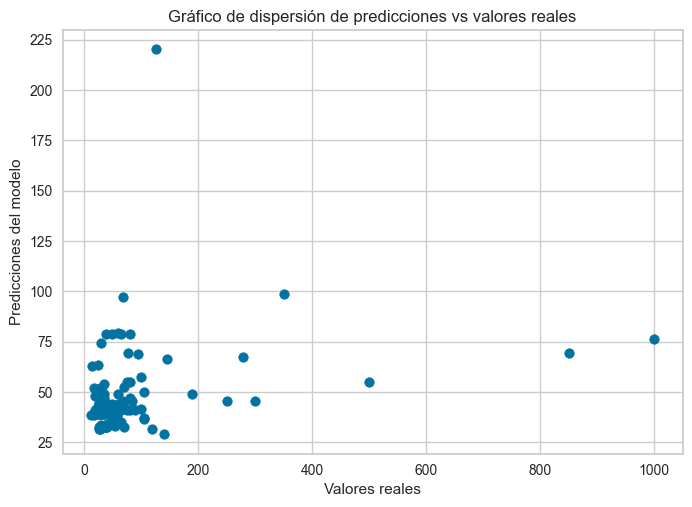

In [21]:

# y_test son los valores reales y y_pred son las predicciones del modelo
plt.scatter(y_test, y_pred_hip)
plt.xlabel("Valores reales")
plt.ylabel("Predicciones del modelo")
plt.title("Gráfico de dispersión de predicciones vs valores reales")
plt.show()


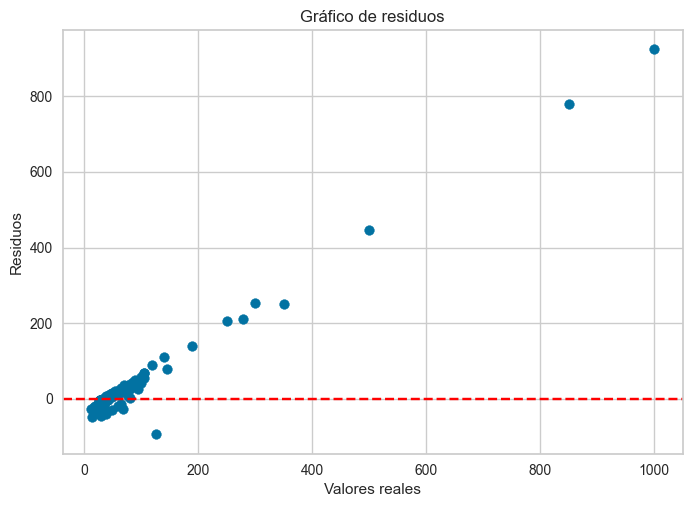

In [22]:
residuals = y_test - y_pred_hip
plt.scatter(y_test, residuals)
plt.xlabel("Valores reales")
plt.ylabel("Residuos")
plt.title("Gráfico de residuos")
plt.axhline(y=0, color='red', linestyle='--')  # Línea en cero para referencia
plt.show()


Probar que recomendaciones de modelos nos da la libreria de automl pycaret

Partiendo el set original para modelamiento y pruebas para separar datos que el modelo no conoce y asi testear los resultados de las estimaciones.

In [23]:
data = df.sample(frac=0.9, random_state=786)
data_unseen = df.drop(data.index)

data.reset_index(drop=True, inplace=True)
data_unseen.reset_index(drop=True, inplace=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (364, 9)
Unseen Data For Predictions: (40, 9)


In [24]:
s = setup(data = data, target = 'price', session_id=123,normalize = True,remove_multicollinearity = True, multicollinearity_threshold = 0.3)

,Description,Value
0,Session id,123
1,Target,price
2,Target type,Regression
3,Original data shape,"(364, 9)"
4,Transformed data shape,"(364, 9)"
5,Transformed train set shape,"(254, 9)"
6,Transformed test set shape,"(110, 9)"
7,Numeric features,6
8,Categorical features,2
9,Preprocess,True


In [25]:
best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
dummy,Dummy Regressor,42.4854,7959.8289,79.0331,-0.0240,0.7555,0.9017,1.4680
llar,Lasso Least Angle Regression,41.7046,8048.8843,79.7508,-0.0542,0.7522,0.8756,1.4530
huber,Huber Regressor,35.7087,8358.5855,80.9714,-0.0694,0.6799,0.5336,1.4350
en,Elastic Net,42.1208,8123.1411,80.3810,-0.0815,0.7610,0.8800,1.4100
par,Passive Aggressive Regressor,36.9116,8518.4739,82.1607,-0.1140,0.7252,0.5584,1.4250
br,Bayesian Ridge,42.8311,8273.9734,81.4082,-0.1199,0.7770,0.8911,1.4430
lasso,Lasso Regression,43.9074,8517.9751,83.1003,-0.1882,0.8099,0.9134,1.4550
ridge,Ridge Regression,44.5349,8575.6286,83.5153,-0.2048,0.8484,0.9280,1.4050
omp,Orthogonal Matching Pursuit,43.7356,8598.9582,83.6231,-0.2062,0.7979,0.9031,1.3920
lar,Least Angle Regression,44.5813,8583.0042,83.5639,-0.2068,0.8470,0.9291,1.5800


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

Entrenaremos un LightGBM con las variables seleccionadas anteriormente mediante el metodo selectKbest y  feature selection con ajuste de hiperparametros para ver como se comporta:

In [26]:
# Crea el regresor LightGBM
lgb_model = lgb.LGBMRegressor(objective='regression', random_state=42)

# Entrena el modelo en los datos de entrenamiento
lgb_model.fit(X_train, y_train)

# Realiza predicciones en el conjunto de prueba
y_pred = lgb_model.predict(X_test)



[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 293
[LightGBM] [Info] Number of data points in the train set: 282, number of used features: 9
[LightGBM] [Info] Start training from score 62.276596
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

In [27]:
# Evaluar el rendimiento del modelo utilizando el error cuadrático medio (Mean Squared Error)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2} \nMean Squared Error: {mse}\nMean Absolute Error: {mae}\nRoot Mean Squared Error: {rmse}")

R-squared: 0.05099869123221823 
Mean Squared Error: 15690.996835168526
Mean Absolute Error: 49.50471750299103
Root Mean Squared Error: 125.26370917056754


In [28]:
# Define la grilla de hiperparámetros a explorar
"""param_grid = {
    'boosting_type': ['gbdt', 'dart', 'goss'],
    'num_leaves': [20, 30, 40, 50, 60],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [5, 10, 15, 20],
    'n_estimators': [100, 200, 300, 400]
}

# Crea un objeto RandomizedSearchCV
random_search = RandomizedSearchCV(
    lgb_model, param_distributions=param_grid, n_iter=50, cv=3, scoring='neg_mean_squared_error', random_state=42
)"""



"param_grid = {\n    'boosting_type': ['gbdt', 'dart', 'goss'],\n    'num_leaves': [20, 30, 40, 50, 60],\n    'learning_rate': [0.01, 0.05, 0.1, 0.2],\n    'max_depth': [5, 10, 15, 20],\n    'n_estimators': [100, 200, 300, 400]\n}\n\n# Crea un objeto RandomizedSearchCV\nrandom_search = RandomizedSearchCV(\n    lgb_model, param_distributions=param_grid, n_iter=50, cv=3, scoring='neg_mean_squared_error', random_state=42\n)"

In [29]:
# Realiza la búsqueda aleatoria en los datos de entrenamiento
"""random_search.fit(X_train, y_train)

# Muestra los mejores hiperparámetros encontrados
print("Mejores hiperparámetros encontrados:")
print(random_search.best_params_)

# Realiza predicciones en el conjunto de prueba con el mejor modelo encontrado
y_pred = random_search.best_estimator_.predict(X_test)"""

'random_search.fit(X_train, y_train)\n\n# Muestra los mejores hiperparámetros encontrados\nprint("Mejores hiperparámetros encontrados:")\nprint(random_search.best_params_)\n\n# Realiza predicciones en el conjunto de prueba con el mejor modelo encontrado\ny_pred = random_search.best_estimator_.predict(X_test)'

In [30]:
# Evaluar el rendimiento del modelo utilizando el error cuadrático medio (Mean Squared Error)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)


rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)


print(f"R-squared: {r2} \nMean Squared Error: {mse}\nMean Absolute Error: {mae}\nRoot Mean Squared Error: {rmse}")

R-squared: 0.05099869123221823 
Mean Squared Error: 15690.996835168526
Mean Absolute Error: 49.50471750299103
Root Mean Squared Error: 125.26370917056754


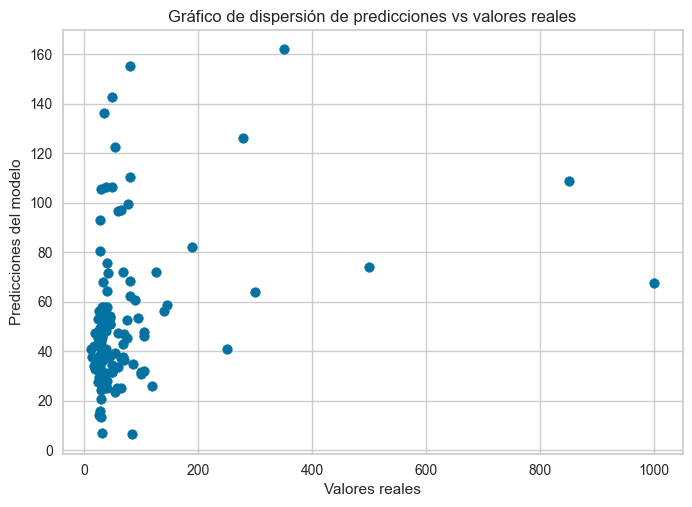

In [31]:

# y_test son los valores reales y y_pred son las predicciones del modelo
plt.scatter(y_test, y_pred)
plt.xlabel("Valores reales")
plt.ylabel("Predicciones del modelo")
plt.title("Gráfico de dispersión de predicciones vs valores reales")
plt.show()


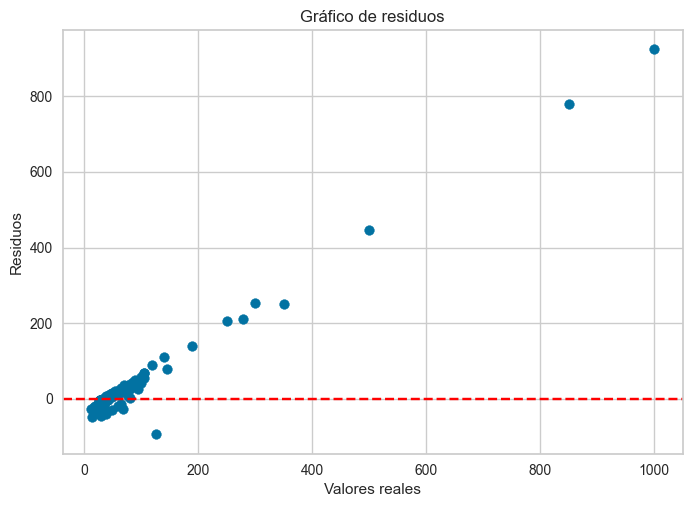

In [32]:
residuals = y_test - y_pred_hip
plt.scatter(y_test, residuals)
plt.xlabel("Valores reales")
plt.ylabel("Residuos")
plt.title("Gráfico de residuos")
plt.axhline(y=0, color='red', linestyle='--')  # Línea en cero para referencia
plt.show()


In [33]:

# Ruta del archivo donde guardarás el modelo
ruta_archivo_modelo = "../modelos/lgbm_shared_room.joblib"

# Guardar el modelo usando joblib
joblib.dump(lgb_model, ruta_archivo_modelo)

['../modelos/lgbm_shared_room.joblib']